### Import necessary libraries

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
import numpy as np
from scipy import stats
from sklearn.preprocessing import StandardScaler
import requests
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
import pickle

### loading datasets

In [3]:
df_remax=pd.read_csv('remax_vente.csv')

In [4]:
df_star_vente=pd.read_csv('properstar_vente.csv')
df_star_vente_commercial=pd.read_csv('properstar_commercial_vente.csv')
df_star=pd.concat([df_star_vente,df_star_vente_commercial])

## Data exploration

### Properstar data

In [5]:
df_star.head(3)

statut                                         link  \
0  Vente  https://www.properstar.fr/annonce/104215563   
1  Vente  https://www.properstar.fr/annonce/102753772   
2  Vente  https://www.properstar.fr/annonce/104409743   

                                               title              address  \
0                Maison √† vendre √† Ez Zahra, Tunisie             Ez Zahra   
1  Appartement √† vendre √† Jardins de Carthage, Tu...  Jardins De Carthage   
2           Appartement √† vendre √† Gammarth, Tunisie             Gammarth   

        prix  Pi√®ces  Etages  Chambres  Salles de bains  Toilettes  ...  \
0      250 ‚Ç¨     7.0     1.0       5.0              2.0        1.0  ...   
1  130‚ÄØ929 ‚Ç¨     2.0     9.0       1.0              1.0        1.0  ...   
2  418‚ÄØ372 ‚Ç¨     6.0     2.0       5.0              5.0        2.0  ...   

   Vue sur la for√™t Vue sur la montagne Centre de remise en forme Hammam  \
0               NaN                 NaN                       NaN    NaN   
1               NaN                 NaN                       NaN    NaN   
2               NaN                 NaN                       NaN    NaN   

   Vue du village Vue du port Vue sur la campagne Garage  Vue sur la verdure  \
0             NaN         NaN                 NaN    NaN                 NaN   
1             NaN         NaN                 NaN    NaN                 NaN   
2             NaN         NaN                 NaN    NaN                 NaN   

   Vue sur le parc  
0              NaN  
1              NaN  
2              NaN  

[3 rows x 93 columns]

In [6]:
df_star.shape

(521, 93)

In [7]:
df_star.columns

Index(['statut', 'link', 'title', 'address', 'prix', 'Pi√®ces', 'Etages',
       'Chambres', 'Salles de bains', 'Toilettes', 'Places de parc ext√©rieur',
       'Habitable', 'Total', 'Alarme', '1', 'Ascenseur', 'Balcon', 'Type',
       'Ann√©e de construction', 'Appartements', 'Piscine', 'Terrasse',
       'Climatisation', 'Concierge 24/7', 'Internet', 'Parking', 'S√©curit√©',
       'A√©roport', 'Autoroute', 'Centre-ville', 'Ecole primaire / √©l√©mentaire',
       'Ecole secondaire', 'Garderie', 'H√¥pital ou clinique', 'Magasins',
       'Universit√©', 'Orientation Nord', 'Vue de la rue', 'Vue du ciel',
       'Condition', 'Chauffage', 'Eau chaude', 'D√©chets des eaux us√©es',
       'Centre de sport', 'Docteur', 'Parking public', 'Supermarch√©', 'Taxi',
       'Transports publics', 'Standing', 'Terrain', 'Jardin', 'Meubl√©',
       'Places de parc int√©rieures', 'Machine √† laver',
       'T√©l√©vision par satellite', 'Parc', 'Ann√©e de r√©novation', 'Interphone',
       'Station de 

In [10]:
df_star.isna().sum().sort_values(ascending=True).head(25)

statut                     0
link                       0
prix                       0
title                      9
address                    9
Pi√®ces                    62
1                         63
Habitable                 72
Type                      90
Total                    120
Etages                   218
Chambres                 270
Ann√©e de construction    272
Salles de bains          283
Condition                288
Climatisation            291
Chauffage                305
Toilettes                315
Alarme                   322
Eau chaude               324
Centre-ville             339
Magasins                 350
Ascenseur                355
Transports publics       361
Mer                      362
dtype: int64

### Remax

In [111]:
df_remax.head()

statut                                               link  \
0  Vente  https://www.remax.com.tn/fr-tn/biens/apparteme...   
1  Vente  https://www.remax.com.tn/fr-tn/biens/terrain-a...   
2  Vente  https://www.remax.com.tn/fr-tn/biens/etage-de-...   
3  Vente  https://www.remax.com.tn/fr-tn/biens/building/...   
4  Vente  https://www.remax.com.tn/fr-tn/biens/villa/ven...   

                                               title           prix  \
0    Appartement - Vente - Ennasr 1-2 Ariana Tunisie    386,000 TND   
1   Terrain agricole - Vente - Enfida Sousse Tunisie    500,000 TND   
2  Etage de Maison/ Villa - Vente - Hammam Ghez√®z...  2,000,000 TND   
3         Building - Vente - Hammamet Nabeul Tunisie    950,000 TND   
4              Villa - Vente - Akouda Sousse Tunisie    490,000 TND   

                                             address          statut_marche  \
0                      Ennasr 1-2 - Ariana - Tunisie  Nouveau sur le march√©   
1          Enfida - 4030 - Enfida - Sousse - Tunisie      Excellente valeur   
2                  Hammam Ghez√®ze - Nabeul - Tunisie  Nouveau sur le march√©   
3  Cit√© Jawaher 1 - 8050 - Hammamet - Nabeul - Tu...      Excellente valeur   
4                 Akouda - Akouda - Sousse - Tunisie  Nouvelle Construction   

        m¬≤ Surface constructible (m¬≤) Ann√©e/Mois de Construction  \
0      122                        122                    2018/01   
1  250,000                        100                    2019/12   
2      790                        600                    2025/01   
3      304                        769                    2024/03   
4      182                        NaN                        NaN   

   Places de parking  ...  Upgraded interior  Energy Efficient  Tennis Court  \
0               11.0  ...                NaN               NaN           NaN   
1                NaN  ...                NaN               NaN           NaN   
2                4.0  ...                NaN               NaN           NaN   
3                2.0  ...                NaN               NaN           NaN   
4                2.0  ...                NaN               NaN           NaN   

   Ann√©e de construction  Baie Vitr√©e  Garage avec porte automatis√©e  \
0                    NaN          NaN                            NaN   
1                    NaN          NaN                            NaN   
2                    NaN          NaN                            NaN   
3                    NaN          NaN                            NaN   
4                    NaN          NaN                            NaN   

   Garage individuel  Brique  Acc√®s facile en voiture  Villa  
0                NaN     NaN                      NaN    NaN  
1                NaN     NaN                      NaN    NaN  
2                NaN     NaN                      NaN    NaN  
3                NaN     NaN                      NaN    NaN  
4                NaN     NaN                      NaN    NaN  

[5 rows x 148 columns]

In [112]:
df_remax.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 583 entries, 0 to 582
Columns: 148 entries, statut to Villa
dtypes: float64(136), object(12)
memory usage: 674.2+ KB


In [113]:
df_remax.columns

Index(['statut', 'link', 'title', 'prix', 'address', 'statut_marche', 'm¬≤',
       'Surface constructible (m¬≤)', 'Ann√©e/Mois de Construction',
       'Places de parking',
       ...
       'Upgraded interior', 'Energy Efficient', 'Tennis Court',
       'Ann√©e de construction', 'Baie Vitr√©e', 'Garage avec porte automatis√©e',
       'Garage individuel', 'Brique', 'Acc√®s facile en voiture', 'Villa'],
      dtype='object', length=148)

In [114]:
df_remax.isna().sum().sort_values(ascending=True).head(10)

statut                          0
link                            0
title                           0
prix                            0
address                         0
m¬≤                             75
statut_marche                 135
Surface constructible (m¬≤)    154
Nombre de pi√®ces              198
Nombre de chambres            208
dtype: int64

## Data preprocessing

### Column selection

In [115]:
columns_to_keep=['address','Type', 'Habitable', 'Total','Terrain',
       'Pi√®ces', 'Salles de bains', 'Chambres','Garage','Jardin','Balcon','Meubl√©','Piscine','Etages', 'prix']
df_star=df_star[columns_to_keep]
df_star.head()

address         Type Habitable   Total Terrain  Pi√®ces  \
0             Ez Zahra          NaN    380 m¬≤  380 m¬≤     NaN     7.0   
1  Jardins De Carthage  Appartement    103 m¬≤  103 m¬≤     NaN     2.0   
2             Gammarth  Appartement    354 m¬≤  354 m¬≤     NaN     6.0   
3               Sousse  Appartement    135 m¬≤  155 m¬≤     NaN     4.0   
4               Sousse       Maison    630 m¬≤     NaN     NaN     5.0   

   Salles de bains  Chambres Garage Jardin  Balcon Meubl√©  Piscine  Etages  \
0              2.0       5.0    NaN    NaN     NaN    NaN      NaN     1.0   
1              1.0       1.0    NaN    NaN  Balcon    NaN      NaN     9.0   
2              5.0       5.0    NaN    NaN  Balcon    NaN  Piscine     2.0   
3              NaN       3.0    NaN    NaN     NaN    NaN      NaN     5.0   
4              NaN       NaN    NaN    NaN     NaN    NaN      NaN     NaN   

        prix  
0      250 ‚Ç¨  
1  130‚ÄØ929 ‚Ç¨  
2  418‚ÄØ372 ‚Ç¨  
3  177‚ÄØ281 ‚Ç¨  
4  174‚ÄØ572 ‚Ç¨

In [116]:
df_star.info()

<class 'pandas.core.frame.DataFrame'>
Index: 521 entries, 0 to 27
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   address          512 non-null    object 
 1   Type             431 non-null    object 
 2   Habitable        449 non-null    object 
 3   Total            401 non-null    object 
 4   Terrain          118 non-null    object 
 5   Pi√®ces           459 non-null    float64
 6   Salles de bains  238 non-null    float64
 7   Chambres         251 non-null    float64
 8   Garage           1 non-null      object 
 9   Jardin           10 non-null     object 
 10  Balcon           125 non-null    object 
 11  Meubl√©           88 non-null     object 
 12  Piscine          94 non-null     object 
 13  Etages           303 non-null    float64
 14  prix             521 non-null    object 
dtypes: float64(4), object(11)
memory usage: 65.1+ KB


In [117]:
columns_to_keep=['title','address', 'm¬≤', 'Surface constructible (m¬≤)','Surface Terrain (m¬≤)',
       'Nombre de pi√®ces', 'Nombre salles de bain', 'Nombre de chambres',
       'Garage','Garage individuel','Garage avec porte automatis√©e','Jardin',
       'Balcon','Meubl√©','Piscine','Piscine ext√©rieure',"Nombre d'√©tages", 'prix']
df_remax=df_remax[columns_to_keep]
df_remax.head(3)


title  \
0    Appartement - Vente - Ennasr 1-2 Ariana Tunisie   
1   Terrain agricole - Vente - Enfida Sousse Tunisie   
2  Etage de Maison/ Villa - Vente - Hammam Ghez√®z...   

                                     address       m¬≤  \
0              Ennasr 1-2 - Ariana - Tunisie      122   
1  Enfida - 4030 - Enfida - Sousse - Tunisie  250,000   
2          Hammam Ghez√®ze - Nabeul - Tunisie      790   

  Surface constructible (m¬≤) Surface Terrain (m¬≤)  Nombre de pi√®ces  \
0                        122                  NaN               NaN   
1                        100              250,000               2.0   
2                        600                  660               5.0   

   Nombre salles de bain  Nombre de chambres  Garage  Garage individuel  \
0                    NaN                 NaN     1.0                NaN   
1                    1.0                 NaN     NaN                NaN   
2                    7.0                 8.0     NaN                NaN   

   Garage avec porte automatis√©e  Jardin  Balcon  Meubl√©  Piscine  \
0                            NaN     NaN     NaN     NaN      NaN   
1                            NaN     NaN     NaN     NaN      NaN   
2                            NaN     1.0     1.0     NaN      NaN   

   Piscine ext√©rieure  Nombre d'√©tages           prix  
0                 NaN              2.0    386,000 TND  
1                 NaN              NaN    500,000 TND  
2                 NaN              2.0  2,000,000 TND

In [118]:
df_remax.rename(columns={
    'm¬≤': 'Habitable',
    'Surface constructible (m¬≤)': 'Terrain',
    'Surface Terrain (m¬≤)': 'Total',
    'Nombre de chambres':'Chambres',
    'Nombre de pi√®ces':'Pi√®ces',
    'Nombre salles de bain':'Salles de bains',
    "Nombre d'√©tages":'Etages'
}, inplace=True)
df_remax.head(1)

title  \
0  Appartement - Vente - Ennasr 1-2 Ariana Tunisie   

                         address Habitable Terrain Total  Pi√®ces  \
0  Ennasr 1-2 - Ariana - Tunisie       122     122   NaN     NaN   

   Salles de bains  Chambres  Garage  Garage individuel  \
0              NaN       NaN     1.0                NaN   

   Garage avec porte automatis√©e  Jardin  Balcon  Meubl√©  Piscine  \
0                            NaN     NaN     NaN     NaN      NaN   

   Piscine ext√©rieure  Etages         prix  
0                 NaN     2.0  386,000 TND

### Transforming column types and reshaping data

### properstar

#### Prix column

In [119]:
df_remax['prix'].sample(3)

9         755,000 TND
456       245,000 TND
253    Nous consulter
Name: prix, dtype: object

In [120]:
df_star['prix'].sample(3)
#prices are in euro => we need to convert them to TND

486    217‚ÄØ012 ‚Ç¨
363            0
59     126‚ÄØ414 ‚Ç¨
Name: prix, dtype: object

In [121]:
#update the price column
df_star['prix'] = df_star['prix'].apply(lambda x: str(x).replace('‚Ç¨','') if isinstance(x, str) else x)
df_star['prix'] = df_star['prix'].apply(lambda x: str(x).replace('\u202f', '') if isinstance(x, str) else x)
df_star['prix'] = df_star['prix'].apply(lambda x: str(x).replace(' ','') if isinstance(x, str) else x)
df_star['prix'] = df_star['prix'].apply(lambda x: x.strip() if isinstance(x, str) else x)
df_star['prix'] = df_star['prix'].apply(lambda x: x + "000" if isinstance(x, str) and len(x) < 4 else x)
df_star['prix'] = pd.to_numeric(df_star['prix'], errors='coerce')


In [122]:
API_KEY = "cur_live_VxYPVVMtGszXGu8LDX9l4AbamFmdEfbOYFDt0ojS"  
API_URL = f"https://api.currencyapi.com/v3/latest?apikey={API_KEY}&currencies=TND&base_currency=EUR"
# Fetch exchange rate from API
response = requests.get(API_URL)
data = response.json()
# Extract the exchange rate
eur_to_tnd_rate = data['data']['TND']['value']
# Convert 'prix' column from EUR to TND
df_star['prix'] = df_star['prix'] * eur_to_tnd_rate
df_star['prix'] = df_star['prix'].apply(lambda x: str(int(x)) if isinstance(x, (int, float)) else x)
df_star['prix'] = pd.to_numeric(df_star['prix'], errors='coerce')


#### Habitable,Total and Terrain

In [123]:
df_star[['Habitable','Total','Terrain']].sample(1)

Habitable Total Terrain
484       NaN   NaN  160 m¬≤

In [124]:
df_remax[['Habitable','Total','Terrain']].sample(1)

Habitable Total Terrain
144       245   245     120

In [125]:
def clean_size_column(df, col):
    """
    Cleans a size-related column by:
    1. Removing 'm¬≤' and any non-breaking spaces.
    2. Stripping leading/trailing spaces.
    3. Converting cleaned values to numeric (float).
    4. Handling missing or invalid values gracefully.
    """
    df[col] = df[col].astype(str)  # Convert all to string to prevent errors
    df[col] = df[col].str.replace('m¬≤', '', regex=False)  # Remove 'm¬≤'
    df[col] = df[col].str.replace('\u202f', '', regex=False)  # Remove non-breaking spaces
    df[col] = df[col].str.replace(' ', '', regex=False)  # Remove normal spaces
    df[col] = df[col].str.strip()  # Strip leading/trailing spaces
    df[col] = pd.to_numeric(df[col], errors='coerce')  # Convert to float, setting errors to NaN

# Example usage
columns_to_clean = ['Habitable', 'Total', 'Terrain']  # List of size-related columns
for col in columns_to_clean:
    clean_size_column(df_star, col)

# Check the cleaned columns
df_star[columns_to_clean].head()


Habitable  Total  Terrain
0      380.0  380.0      NaN
1      103.0  103.0      NaN
2      354.0  354.0      NaN
3      135.0  155.0      NaN
4      630.0    NaN      NaN

#### Type column

In [126]:
df_star['Type'].value_counts()

Type
Appartement    293
Maison         125
Commercial      13
Name: count, dtype: int64

In [127]:
df_star['Type'] = df_star['Type'].replace({'Appartement': 'Residential','Maison':'Residential'})
df_star['Type'].value_counts()

Type
Residential    418
Commercial      13
Name: count, dtype: int64

### remax

#### title column

In [128]:
df_remax[['title']].sample(3)

title
581  Terrain - Vente - Djerba - Midoun M√©denine Tun...
157         Villa - Vente - El Menzah 6 Ariana Tunisie
106     Villa - Vente - Carthage Salambo Tunis Tunisie

In [129]:
df_remax['title'] = df_remax['title'].str.split('-').str[0]
# Remove trailing/leading spaces
df_remax['Type'] = df_remax['title'].str.strip()

# Handle specific cases for "1" and "6 and More"
df_remax = df_remax[ (df_remax['Type']!='6 and More') & (df_remax['Type']!='1') ]

# Optional: categorize property types
def categorize_property(property_type):
    if property_type in ["Appartement", "Villa", "Maison", "Duplex", "Penthouse", "Studio", "R√©sidence"]:
        return "Residential"
    elif property_type in ["Commercial", "Showroom", "Bureau", "Office", "Local Commercial", "Building"]:
        return "Commercial"
    elif property_type in ["Terrain", "Lot", "Land", "Agricole"]:
        return "Land"
    elif property_type in ["H√¥tel", "Warehouse", "Usine", "Entrep√¥t", "Industrie"]:
        return "Industrial"
    else:
        return "Other"
df_remax['Type'] = df_remax['Type'].apply(categorize_property)
df_remax=df_remax.drop(columns=['title'])
df_remax['Type'].value_counts()

Type
Residential    354
Other          113
Land            90
Commercial      22
Name: count, dtype: int64

#### other columns

In [130]:
df_remax.sample(1)

address Habitable Terrain Total  Pi√®ces  \
314  2036 - Ain Zaghouan - Tunis - Tunisie       134     134   NaN     4.0   

     Salles de bains  Chambres  Garage  Garage individuel  \
314              1.0       3.0     NaN                NaN   

     Garage avec porte automatis√©e  Jardin  Balcon  Meubl√©  Piscine  \
314                            NaN     NaN     1.0     NaN      NaN   

     Piscine ext√©rieure  Etages         prix         Type  
314                 NaN     5.0  340,000 TND  Residential

In [131]:
#change column types
df_remax['Habitable'] = df_remax['Habitable'].apply(lambda x: str(x).replace(',', '.') if isinstance(x, str) else x)
df_remax['Habitable'] = pd.to_numeric(df_remax['Habitable'], errors='coerce')
df_remax['Total'] = df_remax['Total'].apply(lambda x: str(x).replace(',', '.') if isinstance(x, str) else x)
df_remax['Total'] = pd.to_numeric(df_remax['Total'], errors='coerce')
df_remax['Terrain'] = df_remax['Terrain'].apply(lambda x: str(x).replace(',', '.') if isinstance(x, str) else x)
df_remax['Terrain'] = pd.to_numeric(df_remax['Terrain'], errors='coerce')

df_remax['prix'] = df_remax['prix'].apply(lambda x: str(x).replace('TND','') if isinstance(x, str) else x)
df_remax['prix'] = df_remax['prix'].apply(lambda x: str(x).replace(',','') if isinstance(x, str) else x)
df_remax['prix'] = df_remax['prix'].apply(lambda x: x.strip() if isinstance(x, str) else x)
df_remax['prix'] = pd.to_numeric(df_remax['prix'], errors='coerce')

columns_with_zero=['Garage','Garage individuel','Garage avec porte automatis√©e','Jardin','Balcon','Meubl√©','Piscine','Piscine ext√©rieure']
for col in columns_with_zero:
    df_remax[col]=df_remax[col].fillna(0)
df_remax.info()

<class 'pandas.core.frame.DataFrame'>
Index: 579 entries, 0 to 582
Data columns (total 18 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   address                        579 non-null    object 
 1   Habitable                      503 non-null    float64
 2   Terrain                        425 non-null    float64
 3   Total                          296 non-null    float64
 4   Pi√®ces                         383 non-null    float64
 5   Salles de bains                371 non-null    float64
 6   Chambres                       373 non-null    float64
 7   Garage                         579 non-null    float64
 8   Garage individuel              579 non-null    float64
 9   Garage avec porte automatis√©e  579 non-null    float64
 10  Jardin                         579 non-null    float64
 11  Balcon                         579 non-null    float64
 12  Meubl√©                         579 non-null    float

In [132]:
df_remax.sample(1)

address  Habitable  Terrain  Total  Pi√®ces  \
547  Jardins de Carthage - Tunis - Tunisie      160.0    160.0    NaN     3.0   

     Salles de bains  Chambres  Garage  Garage individuel  \
547              2.0       2.0     0.0                0.0   

     Garage avec porte automatis√©e  Jardin  Balcon  Meubl√©  Piscine  \
547                            0.0     0.0     0.0     0.0      0.0   

     Piscine ext√©rieure  Etages      prix         Type  
547                 0.0     2.0  778550.0  Residential

In [133]:
df_remax['Garage'] = df_remax[['Garage', 'Garage individuel', 'Garage avec porte automatis√©e']].max(axis=1)

In [134]:
df_remax['Piscine'] = df_remax[['Piscine', 'Piscine ext√©rieure']].max(axis=1)

In [135]:
#drop columns that we don't need
columns_to_drop=['Garage individuel', 'Garage avec porte automatis√©e','Piscine ext√©rieure']
df_remax=df_remax.drop(columns_to_drop,axis=1)
df_remax.head(1)

address  Habitable  Terrain  Total  Pi√®ces  \
0  Ennasr 1-2 - Ariana - Tunisie      122.0    122.0    NaN     NaN   

   Salles de bains  Chambres  Garage  Jardin  Balcon  Meubl√©  Piscine  Etages  \
0              NaN       NaN     1.0     0.0     0.0     0.0      0.0     2.0   

       prix         Type  
0  386000.0  Residential

#### combine the two dataframes into one

In [136]:
df=pd.concat([df_remax,df_star])
print(df.shape)
df.head(3)

(1100, 15)


address  Habitable  Terrain  Total  \
0              Ennasr 1-2 - Ariana - Tunisie      122.0    122.0    NaN   
1  Enfida - 4030 - Enfida - Sousse - Tunisie      250.0    100.0  250.0   
2          Hammam Ghez√®ze - Nabeul - Tunisie      790.0    600.0  660.0   

   Pi√®ces  Salles de bains  Chambres Garage Jardin Balcon Meubl√© Piscine  \
0     NaN              NaN       NaN    1.0    0.0    0.0    0.0     0.0   
1     2.0              1.0       NaN    0.0    0.0    0.0    0.0     0.0   
2     5.0              7.0       8.0    0.0    1.0    1.0    0.0     0.0   

   Etages       prix         Type  
0     2.0   386000.0  Residential  
1     NaN   500000.0        Other  
2     2.0  2000000.0        Other

In [137]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1100 entries, 0 to 27
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   address          1091 non-null   object 
 1   Habitable        952 non-null    float64
 2   Terrain          543 non-null    float64
 3   Total            697 non-null    float64
 4   Pi√®ces           842 non-null    float64
 5   Salles de bains  609 non-null    float64
 6   Chambres         624 non-null    float64
 7   Garage           580 non-null    object 
 8   Jardin           589 non-null    object 
 9   Balcon           704 non-null    object 
 10  Meubl√©           667 non-null    object 
 11  Piscine          673 non-null    object 
 12  Etages           635 non-null    float64
 13  prix             1008 non-null   float64
 14  Type             1010 non-null   object 
dtypes: float64(8), object(7)
memory usage: 137.5+ KB


### Data cleaning

In [138]:
df_clean=df.dropna(subset=['prix'])
df_clean.shape

(1008, 15)

In [139]:
df_clean['Jardin'].value_counts()

Jardin
0.0         279
1.0         208
Jardin        2
10000 m¬≤      1
129 m¬≤        1
330 m¬≤        1
300 m¬≤        1
270 m¬≤        1
216 m¬≤        1
421 m¬≤        1
245 m¬≤        1
Name: count, dtype: int64

In [140]:
df_clean['Jardin'].fillna(0,inplace=True)
df_clean['Jardin'] = df_clean['Jardin'].apply(lambda x: 1 if x != 0.0 else 0)
df_clean['Jardin'].value_counts()

C:\Users\MSI\AppData\Local\Temp\ipykernel_14516\3393552808.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_clean['Jardin'].fillna(0,inplace=True)
C:\Users\MSI\AppData\Local\Temp\ipykernel_14516\3393552808.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['Jardin'].fillna(0,inplace=True)
C:\Users\MSI\AppData\Local\Temp\ipykern

Jardin
0    790
1    218
Name: count, dtype: int64

In [141]:
df_clean['Balcon'].value_counts()

Balcon
0.0       328
1.0       159
Balcon    125
Name: count, dtype: int64

In [142]:
df_clean['Balcon'].fillna(0,inplace=True)
df_clean['Balcon'] = df_clean['Balcon'].apply(lambda x: 1 if x != 0.0 else 0)
df_clean['Balcon'].value_counts()

C:\Users\MSI\AppData\Local\Temp\ipykernel_14516\234478673.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_clean['Balcon'].fillna(0,inplace=True)
C:\Users\MSI\AppData\Local\Temp\ipykernel_14516\234478673.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['Balcon'].fillna(0,inplace=True)
C:\Users\MSI\AppData\Local\Temp\ipykernel

Balcon
0    724
1    284
Name: count, dtype: int64

In [143]:
df_clean['Meubl√©'].value_counts()

Meubl√©
0.0       431
Meubl√©     88
1.0        56
Name: count, dtype: int64

In [144]:
df_clean['Meubl√©'].fillna(0,inplace=True)
df_clean['Meubl√©'] = df_clean['Meubl√©'].apply(lambda x: 1 if x != 0.0 else 0)
df_clean['Meubl√©'].value_counts()

C:\Users\MSI\AppData\Local\Temp\ipykernel_14516\1602645294.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_clean['Meubl√©'].fillna(0,inplace=True)
C:\Users\MSI\AppData\Local\Temp\ipykernel_14516\1602645294.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['Meubl√©'].fillna(0,inplace=True)
C:\Users\MSI\AppData\Local\Temp\ipyke

Meubl√©
0    864
1    144
Name: count, dtype: int64

In [145]:
df_clean['Piscine'].value_counts()

Piscine
0.0        405
Piscine     94
1.0         82
Name: count, dtype: int64

In [146]:
df_clean['Piscine'].fillna(0,inplace=True)
df_clean['Piscine'] = df_clean['Piscine'].apply(lambda x: 1 if x != 0.0 else 0)
df_clean['Piscine'].value_counts()

C:\Users\MSI\AppData\Local\Temp\ipykernel_14516\2679576601.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_clean['Piscine'].fillna(0,inplace=True)
C:\Users\MSI\AppData\Local\Temp\ipykernel_14516\2679576601.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['Piscine'].fillna(0,inplace=True)
C:\Users\MSI\AppData\Local\Temp\ipyke

Piscine
0    832
1    176
Name: count, dtype: int64

In [147]:
df_clean['Garage'].value_counts()

Garage
0.0       315
1.0       172
Garage      1
Name: count, dtype: int64

In [148]:
df_clean['Garage'].fillna(0,inplace=True)
df_clean['Garage'] = df_clean['Garage'].apply(lambda x: 1 if x != 0.0 else 0)
df_clean['Garage'].value_counts()

C:\Users\MSI\AppData\Local\Temp\ipykernel_14516\51011127.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_clean['Garage'].fillna(0,inplace=True)
C:\Users\MSI\AppData\Local\Temp\ipykernel_14516\51011127.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['Garage'].fillna(0,inplace=True)
C:\Users\MSI\AppData\Local\Temp\ipykernel_1

Garage
0    835
1    173
Name: count, dtype: int64

In [149]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1008 entries, 0 to 27
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   address          999 non-null    object 
 1   Habitable        875 non-null    float64
 2   Terrain          480 non-null    float64
 3   Total            647 non-null    float64
 4   Pi√®ces           776 non-null    float64
 5   Salles de bains  542 non-null    float64
 6   Chambres         557 non-null    float64
 7   Garage           1008 non-null   int64  
 8   Jardin           1008 non-null   int64  
 9   Balcon           1008 non-null   int64  
 10  Meubl√©           1008 non-null   int64  
 11  Piscine          1008 non-null   int64  
 12  Etages           575 non-null    float64
 13  prix             1008 non-null   float64
 14  Type             918 non-null    object 
dtypes: float64(8), int64(5), object(2)
memory usage: 126.0+ KB


In [150]:
def plot_distribution(data,title,xlabel):
    plt.figure(figsize=(10, 6))
    sns.histplot(data, kde=True)  # kde=True will add a kernel density estimate curve to visualize distribution smoothly
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel('Frequency')
    plt.show()

In [151]:
plot_distribution(df_clean['Habitable'],'Habitable Distribution','Habitable')

In [152]:
# Replace missing values with median since the distribution is skwed
df_clean['Habitable'].fillna(df_clean['Habitable'].median(), inplace=True)

C:\Users\MSI\AppData\Local\Temp\ipykernel_14516\1680901862.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_clean['Habitable'].fillna(df_clean['Habitable'].median(), inplace=True)
C:\Users\MSI\AppData\Local\Temp\ipykernel_14516\1680901862.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['Habitable'].fillna(df_clean['Habitable

In [153]:
#df_clean = df_clean[(np.abs(stats.zscore(df_clean["Habitable"])) < 3)]

In [154]:
plot_distribution(df_clean['Etages'],'Etages distribution','Etages')

In [155]:
plot_distribution(df_clean['Total'],'Total distribution','Total')

In [156]:
# Replace missing values with median since the distribution is skwed
df_clean['Total'].fillna(df_clean['Total'].median(), inplace=True)

C:\Users\MSI\AppData\Local\Temp\ipykernel_14516\484258427.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_clean['Total'].fillna(df_clean['Total'].median(), inplace=True)
C:\Users\MSI\AppData\Local\Temp\ipykernel_14516\484258427.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['Total'].fillna(df_clean['Total'].median(), inpla

In [157]:
df_clean['Terrain'] = df_clean['Terrain'].apply(lambda x: str(x).replace(',', '.') if isinstance(x, str) else x)
df_clean['Terrain'] = pd.to_numeric(df_clean['Terrain'], errors='coerce')


C:\Users\MSI\AppData\Local\Temp\ipykernel_14516\2018761651.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['Terrain'] = df_clean['Terrain'].apply(lambda x: str(x).replace(',', '.') if isinstance(x, str) else x)
C:\Users\MSI\AppData\Local\Temp\ipykernel_14516\2018761651.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['Terrain'] = pd.to_numeric(df_clean['Terrain'], errors='coerce')


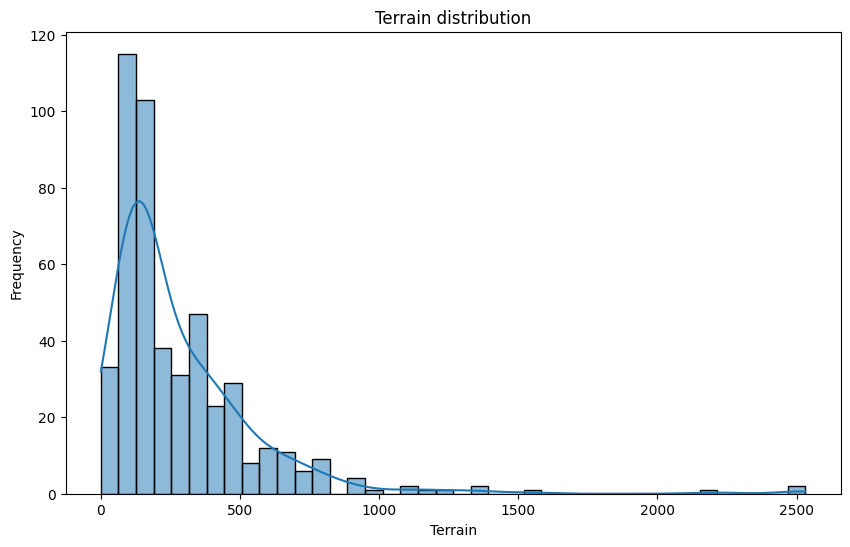

In [158]:
plot_distribution(df_clean['Terrain'],'Terrain distribution','Terrain')

In [159]:
df_clean['Terrain'].fillna(df_clean['Terrain'].median(), inplace=True)

C:\Users\MSI\AppData\Local\Temp\ipykernel_14516\69587176.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_clean['Terrain'].fillna(df_clean['Terrain'].median(), inplace=True)
C:\Users\MSI\AppData\Local\Temp\ipykernel_14516\69587176.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['Terrain'].fillna(df_clean['Terrain'].median(),

In [160]:
#df_clean = df_clean[(np.abs(stats.zscore(df_clean["Total"])) < 3)]

In [161]:
plot_distribution(df_clean['Pi√®ces'],'Pi√®ces distribution','Pi√®ces')

In [162]:
# Replace missing values with median since the distribution is skwed
df_clean['Pi√®ces'].fillna(df_clean['Pi√®ces'].median(), inplace=True)

C:\Users\MSI\AppData\Local\Temp\ipykernel_14516\3906860705.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_clean['Pi√®ces'].fillna(df_clean['Pi√®ces'].median(), inplace=True)
C:\Users\MSI\AppData\Local\Temp\ipykernel_14516\3906860705.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['Pi√®ces'].fillna(df_clean['Pi√®ces'].media

In [163]:
#df_clean = df_clean[(np.abs(stats.zscore(df_clean["Pi√®ces"])) < 3)]

In [164]:
df_clean = df_clean[df_clean['Pi√®ces']<20]

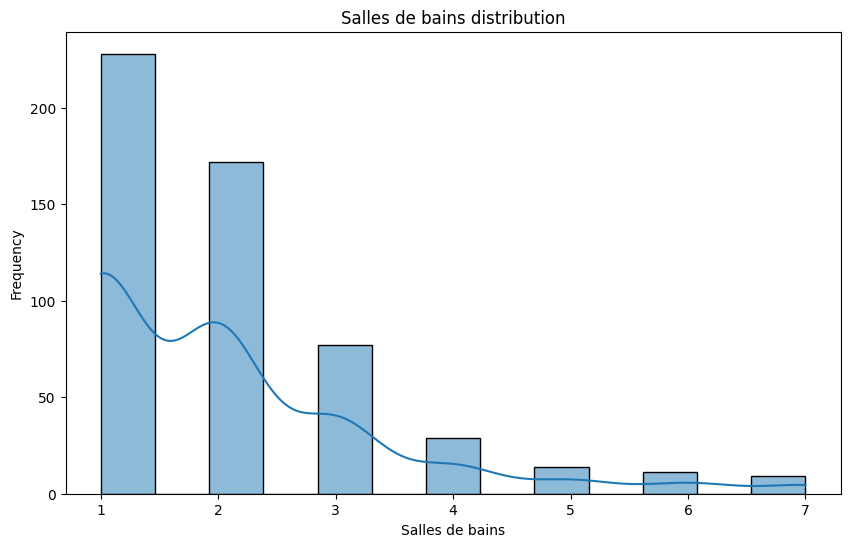

In [165]:
plot_distribution(df_clean['Salles de bains'],'Salles de bains distribution','Salles de bains')

In [166]:
# Replace missing values with mode since the distribution is categorical
df_clean['Salles de bains'].fillna(df_clean['Salles de bains'].mode()[0], inplace=True)

C:\Users\MSI\AppData\Local\Temp\ipykernel_14516\2135588293.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_clean['Salles de bains'].fillna(df_clean['Salles de bains'].mode()[0], inplace=True)


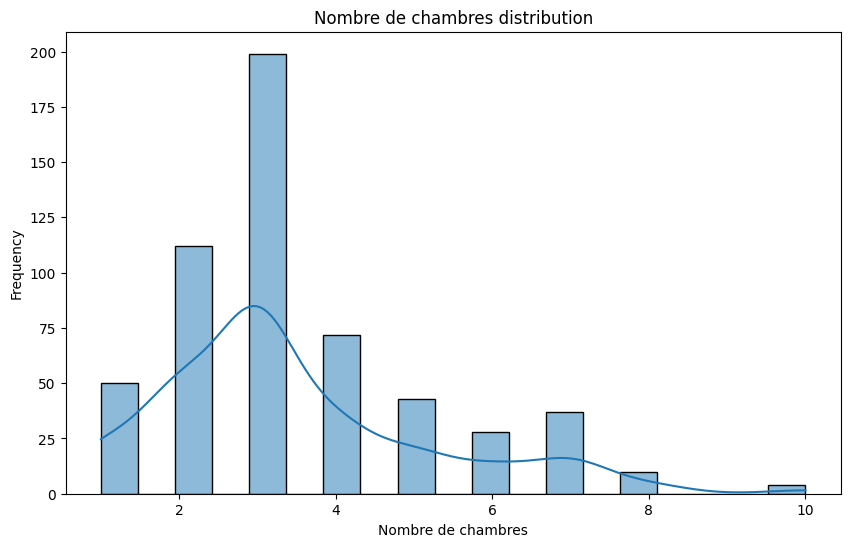

In [167]:
plot_distribution(df_clean['Chambres'],'Nombre de chambres distribution','Nombre de chambres')

In [168]:
# Replace missing values with mode since the distribution is categorical
df_clean['Chambres'].fillna(df_clean['Chambres'].mode()[0], inplace=True)

C:\Users\MSI\AppData\Local\Temp\ipykernel_14516\3383310863.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_clean['Chambres'].fillna(df_clean['Chambres'].mode()[0], inplace=True)


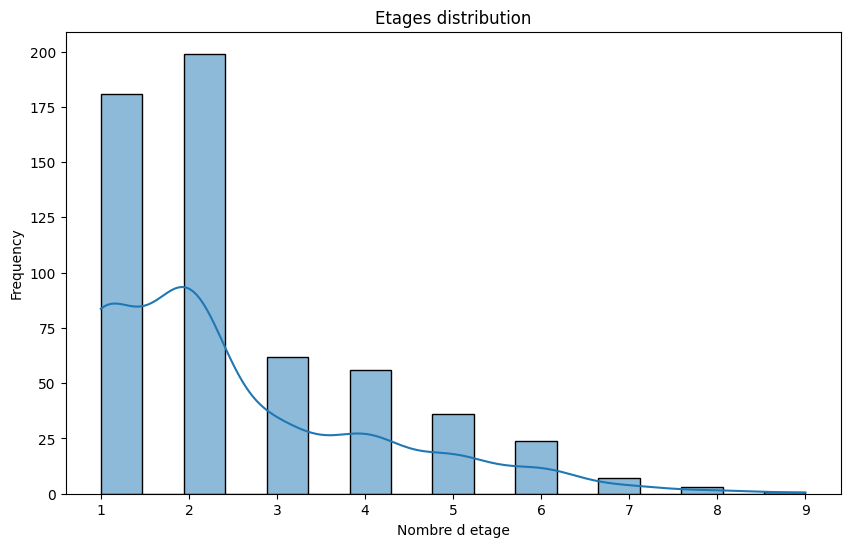

In [169]:
plot_distribution(df_clean['Etages'],'Etages distribution','Nombre d etage')

In [170]:
# Replace missing values with mode since the distribution is categorical
df_clean['Etages'].fillna(df_clean['Etages'].mode()[0], inplace=True)

C:\Users\MSI\AppData\Local\Temp\ipykernel_14516\1566603011.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_clean['Etages'].fillna(df_clean['Etages'].mode()[0], inplace=True)


In [171]:
#df_clean = df_clean[(np.abs(stats.zscore(df_clean["prix"])) < 3)]

In [172]:
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Apply to numerical columns
for col in ["prix", "Habitable", "Total","Terrain", "Pi√®ces"]:
    df_clean = remove_outliers_iqr(df_clean, col)


In [173]:
df_clean['prix'].describe()

count    4.760000e+02
mean     4.446787e+05
std      3.094192e+05
min      0.000000e+00
25%      2.679700e+05
50%      3.860000e+05
75%      5.729032e+05
max      1.604048e+06
Name: prix, dtype: float64

In [174]:
df_clean = df_clean[df_clean['prix'] > 0]

In [175]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 443 entries, 0 to 24
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   address          442 non-null    object 
 1   Habitable        443 non-null    float64
 2   Terrain          443 non-null    float64
 3   Total            443 non-null    float64
 4   Pi√®ces           443 non-null    float64
 5   Salles de bains  443 non-null    float64
 6   Chambres         443 non-null    float64
 7   Garage           443 non-null    int64  
 8   Jardin           443 non-null    int64  
 9   Balcon           443 non-null    int64  
 10  Meubl√©           443 non-null    int64  
 11  Piscine          443 non-null    int64  
 12  Etages           443 non-null    float64
 13  prix             443 non-null    float64
 14  Type             422 non-null    object 
dtypes: float64(8), int64(5), object(2)
memory usage: 55.4+ KB


### Feature engineering

In [176]:
#this part gets us the latitude and longitude 
geolocator = Nominatim(user_agent="my_unique_app_12345")

def get_coordinates(address):
    try:
        location = geolocator.geocode(address, timeout=10)  # Increase timeout
        if location:
            return pd.Series([location.latitude, location.longitude])
    except GeocoderTimedOut:
        time.sleep(1)  # Wait and retry in case of timeout
        return get_coordinates(address)  # Retry
    return pd.Series([None, None])

df_clean[['Latitude', 'Longitude']] = df_clean['address'].apply(get_coordinates)
df_clean[['address','Latitude','Longitude']].head()

address   Latitude  Longitude
0                   Ennasr 1-2 - Ariana - Tunisie  36.862262  10.169746
12  Bouficha - 4010 - Bouficha - Sousse - Tunisie  36.301456  10.454091
13   Borj Chakir - Sidi Hassine - Tunis - Tunisie  36.753115  10.068519
14   Borj Chakir - Sidi Hassine - Tunis - Tunisie  36.753115  10.068519
17                  Ennasr 1-2 - Ariana - Tunisie  36.862262  10.169746

In [177]:
df_clean=df_clean.drop(columns=['address'])
df_clean.head()

Habitable  Terrain   Total  Pi√®ces  Salles de bains  Chambres  Garage  \
0      122.00    122.0  192.00     4.0              1.0       3.0       1   
12      13.85    180.0   13.85     4.0              1.0       3.0       0   
13     163.00    180.0  192.00     4.0              1.0       3.0       0   
14     163.00    180.0  192.00     4.0              1.0       3.0       0   
17     122.00    122.0  192.00     4.0              1.0       3.0       1   

    Jardin  Balcon  Meubl√©  Piscine  Etages      prix         Type   Latitude  \
0        0       0       0        0     2.0  386000.0  Residential  36.862262   
12       0       0       0        0     2.0  380000.0         Land  36.301456   
13       0       0       0        0     2.0     800.0        Other  36.753115   
14       0       0       0        0     2.0     350.0         Land  36.753115   
17       0       0       0        0     2.0  386000.0  Residential  36.862262   

    Longitude  
0   10.169746  
12  10.454091  
13  10.068519  
14  10.068519  
17  10.169746

In [178]:
from sklearn.impute import KNNImputer
# Assuming df is your dataframe
imputer = KNNImputer(n_neighbors=5)  # You can adjust n_neighbors
df_clean[['Latitude', 'Longitude']] = imputer.fit_transform(df_clean[['Latitude', 'Longitude']])
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 443 entries, 0 to 24
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Habitable        443 non-null    float64
 1   Terrain          443 non-null    float64
 2   Total            443 non-null    float64
 3   Pi√®ces           443 non-null    float64
 4   Salles de bains  443 non-null    float64
 5   Chambres         443 non-null    float64
 6   Garage           443 non-null    int64  
 7   Jardin           443 non-null    int64  
 8   Balcon           443 non-null    int64  
 9   Meubl√©           443 non-null    int64  
 10  Piscine          443 non-null    int64  
 11  Etages           443 non-null    float64
 12  prix             443 non-null    float64
 13  Type             422 non-null    object 
 14  Latitude         443 non-null    float64
 15  Longitude        443 non-null    float64
dtypes: float64(10), int64(5), object(1)
memory usage: 58.8+ KB


In [179]:
""""
df_geo=df_clean[['address','Latitude','Longitude']]
df_geo=df_geo.drop_duplicates()
df_geo=df_geo.dropna()
df_geo.to_csv('geocode_cache.csv', index=False)
"""

'"\ndf_geo=df_clean[[\'address\',\'Latitude\',\'Longitude\']]\ndf_geo=df_geo.drop_duplicates()\ndf_geo=df_geo.dropna()\ndf_geo.to_csv(\'geocode_cache.csv\', index=False)\n'

### Encoding

In [180]:
df_clean.head(1)

Habitable  Terrain  Total  Pi√®ces  Salles de bains  Chambres  Garage  \
0      122.0    122.0  192.0     4.0              1.0       3.0       1   

   Jardin  Balcon  Meubl√©  Piscine  Etages      prix         Type   Latitude  \
0       0       0       0        0     2.0  386000.0  Residential  36.862262   

   Longitude  
0  10.169746

In [181]:
# Find the most frequent (mode) value
most_frequent = df_clean['Type'].mode()[0]
# Fill missing values with the most frequent value
df_clean['Type'].fillna(most_frequent, inplace=True)
df_encoded = pd.get_dummies(df_clean, columns=['Type'], drop_first=True)
df_encoded.head()

C:\Users\MSI\AppData\Local\Temp\ipykernel_14516\2319487793.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_clean['Type'].fillna(most_frequent, inplace=True)


Habitable  Terrain   Total  Pi√®ces  Salles de bains  Chambres  Garage  \
0      122.00    122.0  192.00     4.0              1.0       3.0       1   
12      13.85    180.0   13.85     4.0              1.0       3.0       0   
13     163.00    180.0  192.00     4.0              1.0       3.0       0   
14     163.00    180.0  192.00     4.0              1.0       3.0       0   
17     122.00    122.0  192.00     4.0              1.0       3.0       1   

    Jardin  Balcon  Meubl√©  Piscine  Etages      prix   Latitude  Longitude  \
0        0       0       0        0     2.0  386000.0  36.862262  10.169746   
12       0       0       0        0     2.0  380000.0  36.301456  10.454091   
13       0       0       0        0     2.0     800.0  36.753115  10.068519   
14       0       0       0        0     2.0     350.0  36.753115  10.068519   
17       0       0       0        0     2.0  386000.0  36.862262  10.169746   

    Type_Land  Type_Other  Type_Residential  
0       False       False              True  
12       True       False             False  
13      False        True             False  
14       True       False             False  
17      False       False              True

In [182]:
bool_columns = ["Type_Land", "Type_Other", "Type_Residential"]
df_encoded[bool_columns] = df_encoded[bool_columns].astype(int)
df_encoded.head()

Habitable  Terrain   Total  Pi√®ces  Salles de bains  Chambres  Garage  \
0      122.00    122.0  192.00     4.0              1.0       3.0       1   
12      13.85    180.0   13.85     4.0              1.0       3.0       0   
13     163.00    180.0  192.00     4.0              1.0       3.0       0   
14     163.00    180.0  192.00     4.0              1.0       3.0       0   
17     122.00    122.0  192.00     4.0              1.0       3.0       1   

    Jardin  Balcon  Meubl√©  Piscine  Etages      prix   Latitude  Longitude  \
0        0       0       0        0     2.0  386000.0  36.862262  10.169746   
12       0       0       0        0     2.0  380000.0  36.301456  10.454091   
13       0       0       0        0     2.0     800.0  36.753115  10.068519   
14       0       0       0        0     2.0     350.0  36.753115  10.068519   
17       0       0       0        0     2.0  386000.0  36.862262  10.169746   

    Type_Land  Type_Other  Type_Residential  
0           0           0                 1  
12          1           0                 0  
13          0           1                 0  
14          1           0                 0  
17          0           0                 1

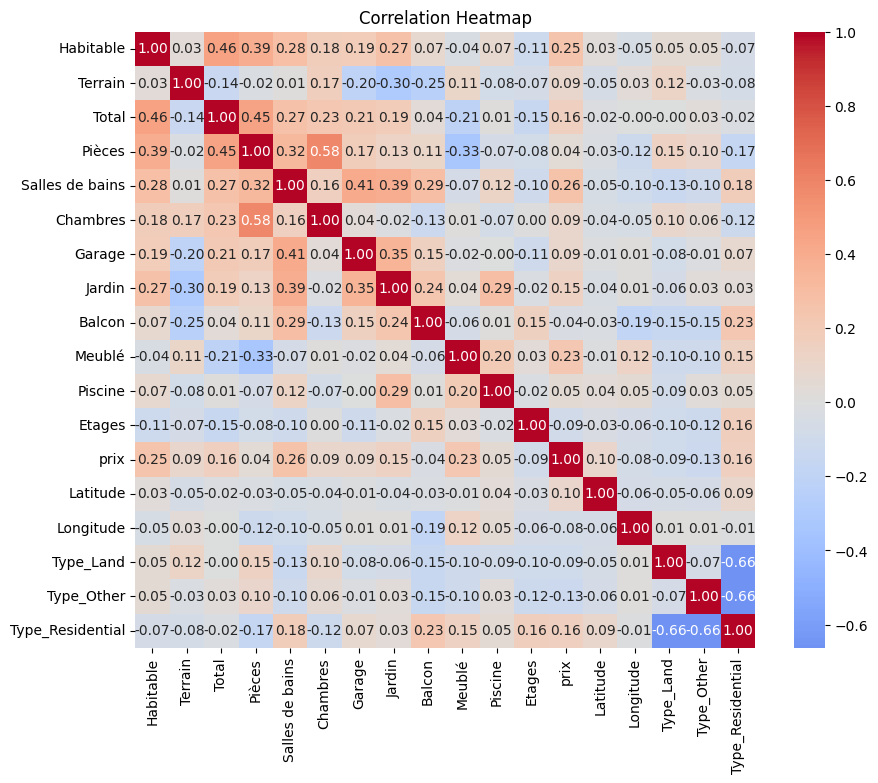

In [183]:
# Filter only numeric columns
df_numeric = df_encoded.select_dtypes(include=["number"])

# Calculate the correlation matrix
corr_matrix = df_numeric.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", center=0)

# Display the heatmap
plt.title("Correlation Heatmap")
plt.show()


In [184]:
syn_df=pd.read_csv('synthatic_data_vente.csv')
syn_df=syn_df.drop(columns='Unnamed: 0')
syn_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Habitable         5000 non-null   float64
 1   Terrain           5000 non-null   float64
 2   Total             5000 non-null   float64
 3   Pi√®ces            5000 non-null   float64
 4   Salles de bains   5000 non-null   float64
 5   Chambres          5000 non-null   float64
 6   Garage            5000 non-null   int64  
 7   Jardin            5000 non-null   int64  
 8   Balcon            5000 non-null   int64  
 9   Meubl√©            5000 non-null   int64  
 10  Piscine           5000 non-null   int64  
 11  Etages            5000 non-null   float64
 12  prix              5000 non-null   float64
 13  Latitude          5000 non-null   float64
 14  Longitude         5000 non-null   float64
 15  Type_Land         5000 non-null   int64  
 16  Type_Other        5000 non-null   int64 

In [185]:
final_df=pd.concat([df_encoded,syn_df])
final_df.shape

(5443, 18)

In [186]:
#final_df.to_csv('final_df_vente.csv') we are gonna use it to generate synthatic data 

### Building the model

In [187]:
X=final_df.drop(columns=['prix'])
y=final_df['prix']
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

In [188]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5443 entries, 0 to 4999
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Habitable         5443 non-null   float64
 1   Terrain           5443 non-null   float64
 2   Total             5443 non-null   float64
 3   Pi√®ces            5443 non-null   float64
 4   Salles de bains   5443 non-null   float64
 5   Chambres          5443 non-null   float64
 6   Garage            5443 non-null   int64  
 7   Jardin            5443 non-null   int64  
 8   Balcon            5443 non-null   int64  
 9   Meubl√©            5443 non-null   int64  
 10  Piscine           5443 non-null   int64  
 11  Etages            5443 non-null   float64
 12  Latitude          5443 non-null   float64
 13  Longitude         5443 non-null   float64
 14  Type_Land         5443 non-null   int64  
 15  Type_Other        5443 non-null   int64  
 16  Type_Residential  5443 non-null   int64  
dty

This code is used to find the best hyperparameters

In [ ]:
"""
# Define parameter grid
param_grid = {
    "n_estimators": [500, 700, 900],
    "learning_rate": [0.01, 0.05, 0.1],
    "max_depth": [5, 7, 9],
    "min_samples_split": [5, 10, 15],
    "min_samples_leaf": [3, 5, 7],
    "subsample": [0.7, 0.9]
}

# Initialize model
gb_regressor = GradientBoostingRegressor(random_state=41)

# Perform Grid Search
grid_search = GridSearchCV(
    gb_regressor, param_grid=param_grid,
    cv=5, scoring="neg_root_mean_squared_error",
    n_jobs=-1, verbose=1
)

# Fit the search
grid_search.fit(X_train, y_train)

# Print best parameters
print("Best Hyperparameters:", grid_search.best_params_)

"""

Fitting 5 folds for each of 486 candidates, totalling 2430 fits
Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 9, 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 500, 'subsample': 0.9}


In [192]:
sgb = GradientBoostingRegressor(
    learning_rate=0.1,
    max_depth=9,
    min_samples_leaf=3,
    min_samples_split=5,
    n_estimators=500,
    subsample=0.9,
    random_state=42
)

# ‚úÖ Train the model
sgb.fit(X_train, y_train)

# ‚úÖ Predict on test data
y_pred = sgb.predict(X_test)

# ‚úÖ Compute Evaluation Metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# ‚úÖ Print results
print(f"üîπ Real RMSE: {rmse:.2f}")
print(f"üîπ Mean Absolute Error: {mae:.2f}")
print(f"üîπ R¬≤ Score: {r2:.4f}")


üîπ Real RMSE: 46612.07
üîπ Mean Absolute Error: 7119.90
üîπ R¬≤ Score: 0.9765


### Download the model

In [191]:
with open('model_vente','wb') as f:
    pickle.dump(sgb,f)